# Fitting Transmission Parameters Diagnostic Output

In [101]:
from collections import namedtuple
from functools import partial
import json
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import palettable
import pandas as pd
import re
import pneumodel_.plotting as plotting
from pneumodel_.plotting import remove_spines, save_figure

In [102]:
%matplotlib inline
set1_colors     = palettable.colorbrewer.qualitative.Set1_9.mpl_colors
dark2_colors    = palettable.colorbrewer.qualitative.Dark2_8.mpl_colors
paired12_colors = palettable.colorbrewer.qualitative.Paired_12.mpl_colors

#### Specify which run

In [103]:
run_name = 'fit-us-transmission-50iter-5000N'
output_dir = os.path.join('/Users/Lucy/Dropbox (hsph.harvard.edu)/Research/Projects/Pneumo-ABM/saved-outputs', run_name)
trial_name = 'trial-0'
trial_dir = os.path.join(output_dir, trial_name)

In [104]:
save_fig = partial(save_figure, folder=os.path.join(output_dir, 'figures', trial_name))

#### Read in data

In [105]:
with open(os.path.join(output_dir, 'configuration', 'configuration.json')) as f:
    config = json.load(f, object_hook=lambda d: namedtuple('Config', d.keys())(*d.values()))

In [106]:
print (config.host)
print (config.population.omega)

Config(mu=0.25, epsilon=0.25, sigmas_file='sigmas_sparc2.json', sigma_sg=0.2, halflife_st=-1, halflife_sg=-1)
1e-06


In [107]:
MAX_ITERS = 250

In [108]:
serotype_names = np.array(pd.read_json(os.path.join(output_dir, 'configuration', config.serotype.serotypes_file))).flatten()

In [109]:
errors = np.array(pd.read_csv(os.path.join(trial_dir , 'prevalence_errors.csv'), header=None))[:MAX_ITERS]
llhs   = np.array(pd.read_csv(os.path.join(trial_dir , 'loglikelihood.csv'), header=None))[:MAX_ITERS]
betas  = np.array(pd.read_csv(os.path.join(trial_dir , 'beta.csv'), header=None)).flatten()[:MAX_ITERS]
ranks  = np.array(pd.read_csv(os.path.join(trial_dir, 'ranks.csv'), header=None))[:MAX_ITERS]

In [110]:
estimated_prevs = np.array(pd.read_csv(os.path.join(trial_dir, 'estimated_prevalences.csv'), header=None))[:MAX_ITERS]
target_prevs    = np.array(pd.read_csv(os.path.join(trial_dir, 'target_prevalences.csv'), header=None))[0]
num_serotypes  = estimated_prevs.shape[1] - 1
num_iterations = estimated_prevs.shape[0] 

In [111]:
target_prevs[:-1].sum()

0.22500002

#### Map serogroup to color for plotting

In [112]:
st2color = {st: dark2_colors[st % len(dark2_colors)] for st in range(num_serotypes)}
st2color[target_prevs.shape[0] - 1] = 'k'

## Sum of squared errors and likelihood

/Users/Lucy/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


['/Users/Lucy/Dropbox (hsph.harvard.edu)/Research/Projects/Pneumo-ABM/saved-outputs/fit-us-transmission-50iter-5000N/figures/trial-0/errors-0.pdf',
 '/Users/Lucy/Dropbox (hsph.harvard.edu)/Research/Projects/Pneumo-ABM/saved-outputs/fit-us-transmission-50iter-5000N/figures/trial-0/errors-0.png']

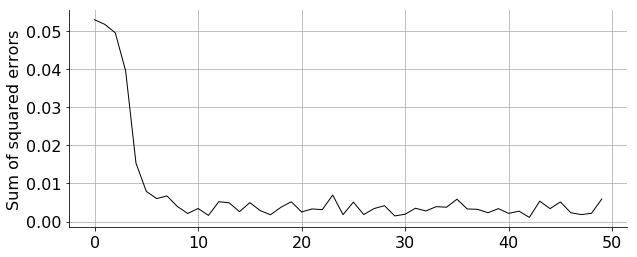

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharex=True)

# plot sum of squared errors
ax.plot(np.sum(np.power(errors, 2), axis=1))
ax.set_ylabel('Sum of squared errors')
ax.grid()
remove_spines(ax)

save_fig(fig, 'errors', exts=['pdf', 'png'])

## Parameter estimates

In [114]:
serogroups = [re.search('(\d+)\w*', s).group(1) for s in serotype_names]
get_sg = lambda st: re.search('(\d+)\w*', st).group(1)

/Users/Lucy/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


0.200662
CPU times: user 13.6 s, sys: 364 ms, total: 14 s
Wall time: 16.8 s


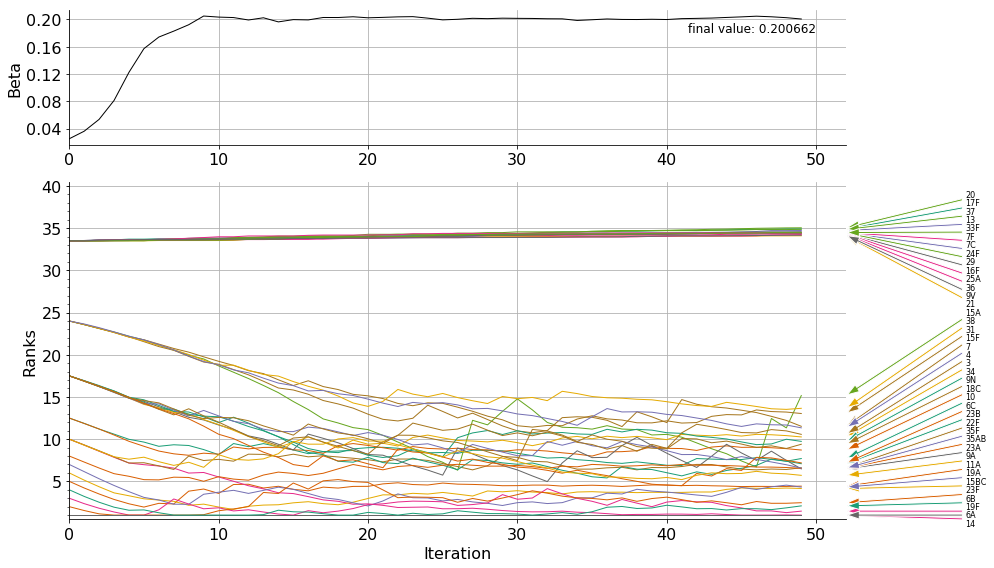

In [115]:
%%time
fig = plt.figure(figsize=(12, 8)) 
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[2, 5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
axes = [ax1, ax2]

# plot betas
ax = axes[0]
ax.plot(betas)
ax.text(num_iterations, betas[-1] * 0.98, 'final value: {:.6f}'.format(betas[-1]), va='top', ha='right', fontsize=12)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
ax.set_ylabel('Beta')
ax.grid(True)
remove_spines(ax)

# plot ranks
ax = axes[1]
ax.set_ylim(0.5, ranks.shape[1] + 0.5)

# annotate with serotype names
ordering = ranks[-1, :].argsort().argsort() # ranking of final set of ranks
annotation_artists = []
for i in range(ranks.shape[1]):
    #ax.plot(ranks[:, i], c=st2color[i])
    has_sibling = serogroups.count(serogroups[i]) > 1
    color = st2color[i] #if has_sibling else '.4'
    ls = '-' #if has_sibling else '--'
    lw = 1 #if has_sibling else 2
    ax.plot(ranks[:, i], c=color, ls=ls, lw=lw)
    artist = ax.annotate(
      serotype_names[i], 
      xy=(num_iterations + 2, ranks[-1, i]), 
      xytext=(num_iterations + 10, ordering[i]),
      va='center',
      fontsize=8,
      arrowprops=dict(facecolor=color, width=2, headwidth=8, shrink=0.01))
#      arrowprops=dict(facecolor=st2color[i], width=2, headwidth=8, shrink=0.01))
    annotation_artists.append(artist)

ax.set_ylabel("Ranks")
ax.set_ylim(0.5, num_serotypes + 0.5)
ax.set_xlim(0, num_iterations + 2)
ax.grid(True)
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.set_xlabel("Iteration")

remove_spines(ax)
fig.tight_layout()

save_fig(fig, 'parameters', exts=['pdf', 'png'], bbox_extra_artists=annotation_artists, bbox_inches='tight', dpi=300)
print (betas[-1])

## Compare Estimated Prevalences and Target Prevalences

In [116]:
estimated_prevs.shape

(50, 41)

/Users/Lucy/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


['/Users/Lucy/Dropbox (hsph.harvard.edu)/Research/Projects/Pneumo-ABM/saved-outputs/fit-us-transmission-50iter-5000N/figures/trial-0/total-prevalence-0.pdf',
 '/Users/Lucy/Dropbox (hsph.harvard.edu)/Research/Projects/Pneumo-ABM/saved-outputs/fit-us-transmission-50iter-5000N/figures/trial-0/total-prevalence-0.png']

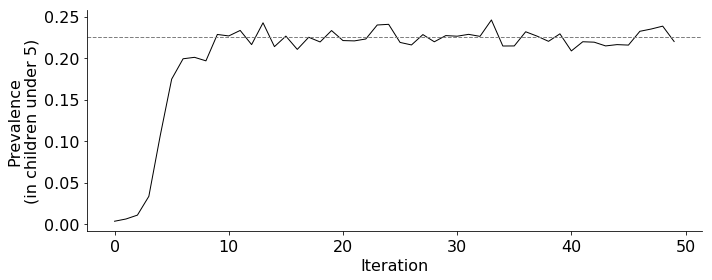

In [117]:
estimated_total_prev = 1 - estimated_prevs[:,-1]
target_total_prev    = 1 - target_prevs[-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(estimated_total_prev)
ax.axhline(y=target_total_prev, c='.5', ls='--')
remove_spines(ax)
ax.set_ylabel('Prevalence\n(in children under 5)')
ax.set_xlabel('Iteration')

fig.tight_layout()
save_fig(fig, 'total-prevalence', exts=['pdf', 'png'])

Prevalence

In [118]:
n = 4

IndexError: index 0 is out of bounds for axis 0 with size 0

/Users/Lucy/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


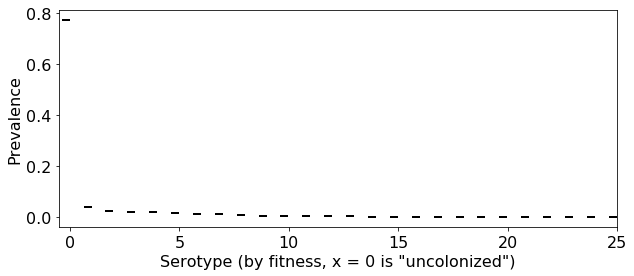

In [119]:
m = 25

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

sorted_idx = target_prevs.argsort()[::-1]
xs = np.arange(len(sorted_idx))

ax.plot(xs - 0.2, target_prevs[sorted_idx], marker='_', mew=2, markersize=8, ls='None')
ax.set_xlim(-0.5, 25)
ax.set_xlabel('Serotype (by fitness, x = 0 is "uncolonized")')


ax.set_ylabel('Prevalence')

a = n * m
b = min(n * m + m, num_iterations)

for x, s in zip(xs, sorted_idx):
  prev_hat = estimated_prevs[a:b, s]
  v = ax.violinplot(prev_hat, [x])
  plotting.style_violin(v, 'k', '.3')

ax.set_ylim(0)
remove_spines(ax)
ax.text(0.5, 0.5, 'Iterations {} to {}'.format(a,b), transform=ax.transAxes)

n += 1

fig.tight_layout()
save_fig(fig, 'estimated-prevs-iters-{}-to-{}'.format(a, b))

Error

In [ ]:
n = 0

In [ ]:
m = 25
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

a = n * m
b = min(n * m + m, num_iterations)

for x, s in zip(xs, sorted_idx):
  prev_hat = estimated_prevs[a:b, s]
  v = ax.violinplot(prev_hat - target_prevs[s], [x], showmeans=True, showmedians=True, showextrema=True)
  plotting.style_violin(v, 'k', '.3')
    
remove_spines(ax)
ax.text(0.5, 0.25, 'Iterations {} to {}'.format(a, b), transform=ax.transAxes)
ax.set_xlim(-0.5, num_serotypes + 0.5)
ax.set_xlabel('Serotype (by fitness, x = 0 is "uncolonized")')

ax.set_ylabel('Prevalence error\n(simulated minus observed)')

ax.axhline(y=0)
n += 1
fig.tight_layout()

save_fig(fig, 'error-iters-{}-to-{}'.format(a, b))

Check that the calculated errors agree with the stored values

In [ ]:
np.all(np.isclose((estimated_prevs - target_prevs), errors, atol=1e-6))

Check that the error in the total prevalence is the sum of the serotype-specific prevalence errors

In [ ]:
np.all(np.isclose(errors[:,:-1].sum(axis=1), -errors[:,-1], atol=1e-6))

#### Compute a moving average

In [ ]:
def moving_average(array, n):
    S = np.cumsum(array, dtype=float)
    S[n:] = (S[n:] - S[:-n]) / n        # average most recent n elements
    S[:n] = S[:n] / np.arange(1, n + 1) # average available elements for the first n windows
    return S

In [ ]:
%%time
window_size = 10
estimated_prevs_mva = np.zeros_like(estimated_prevs)
for i in range(estimated_prevs.shape[1]):
    estimated_prevs_mva[:, i] = moving_average(estimated_prevs[:, i], n=window_size)

#### Look at estimates from each simulation 

In [ ]:
%%time
num_cols = 8
num_rows = int(math.ceil(num_serotypes / float(num_cols)))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 2))

for i, ax in enumerate(axes.flatten()):
    if i > num_serotypes - 1:
        ax.axis('off')
        continue
        
    xs = np.arange(0, num_iterations)
    ys = estimated_prevs[:,i]
    row = i / num_cols
    start = row*num_cols
    end   = min(start + num_cols, num_serotypes - 1)

    ax.set_xlim(0, max(xs) + 1)
    ax.set_ylim(0, max(max(ys), target_prevs[i]))
    
    ax.scatter(xs, ys, c=st2color[i], alpha=0.7, s=20)
    ax.axhline(y=target_prevs[i], c='k', ls='--', lw=2, alpha=0.8)
    ax.plot(xs, estimated_prevs_mva[:, i], c='k', lw=2)
    ax.text(num_iterations / 2, ax.get_ylim()[1] * 0.95, '{} : {:.2f}'.format(serotype_names[i], ranks[-1, i]), va='top', ha='center', 
            fontsize=18, fontweight='bold', color='.3')
    
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(5))    
    
    remove_spines(ax)
    
fig.tight_layout()
save_fig(fig, 'convergence-window-size-{}'.format(window_size), exts=['pdf', 'png'])

## Looks good? Create a ranks.json file 

In [ ]:
print ('final value for beta:', betas[-1])

In [ ]:
num_to_avg = 10
estimated_ranks = ranks[-num_to_avg:,:].mean(axis=0)

In [ ]:
with open('../configuration/ranks-{}.json'.format(run_name.replace('/', '-')), 'w') as json_file:
    json.dump({'ranks': estimated_ranks.tolist()}, json_file)